### Import the Required Libraries

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import time

### Define the Variables

In [2]:
# The grid is referred to as maze in the code.
# Define the maze (7x7): (1, 1) is the start, (6, 6) is the chemical source
maze = np.array([
    [-1, -1, -1, -1, -1, -1, -1],
    [-1,  0,  0, 0,  0,  0, -1],
    [-1,  0,  0, 0,  0,  0, -1],
    [-1,  0,  0, 0,  0,  0, -1],
    [-1,  0,  0, 0,  0,  0, -1],
    [-1,  0,  0,  0,  0,  1, -1],
    [-1, -1, -1, -1, -1, -1, -1]
])

action_size = 4
gamma = 0.99    # Reward discount rate

start_time = time.time()  # Define the start time

### Define the Actor-Critic Neural Network Architecture

In [3]:
# Network to output action probabilities and state values
class ActorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(maze.shape[0] * maze.shape[1], 16)
        self.fc2 = nn.Linear(16, action_size)

    def forward(self, s):
        h = F.relu(self.fc1(s))
        action_prob = F.softmax(self.fc2(h), dim=-1)  # Specify the `dim` argument
        return action_prob

class CriticNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(maze.shape[0] * maze.shape[1] + action_size, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, s, a):
        h = torch.cat([s, a], dim=-1)
        h = F.relu(self.fc1(h))
        value = self.fc2(h)
        return value

### Calculate the Gaussian Plume Concentration Model

In [4]:
# Calculate Gaussian plume concentration at a given position
def calculate_concentration(position):
    distance = np.linalg.norm(position - plume_center)
    concentration = np.exp(-0.5 * (distance / plume_sigma) ** 2)
    return concentration

def estimate_source(particles):
    weights = np.ones(len(particles))  # Assuming equal weights for simplicity

    # Calculate the weighted mean
    weighted_mean = np.average(particles, axis=0, weights=weights)

    # Calculate the weighted variance
    weighted_variance = np.average((particles - weighted_mean) ** 2, axis=0, weights=weights)

    return weighted_mean, weighted_variance

### Initialise the Actor-Critic networks, Action Spaces, and Plume Parameters

In [5]:
actor_net = ActorNet()
critic_net = CriticNet()
optimizer_actor = torch.optim.Adam(actor_net.parameters(), lr=0.001)
optimizer_critic = torch.optim.Adam(critic_net.parameters(), lr=0.001)

# Actions that can be taken in the maze
actions = [
    np.array([ 0,  1]),  # Right
    np.array([ 0, -1]),  # Left
    np.array([-1,  0]),  # Up
    np.array([ 1,  0])   # Down
]

# Gaussian plume parameters
plume_center = np.array([5, 5])
plume_sigma = 1.5

### Implement the Particle Filter

In [6]:
# Generate particle filter estimates for the plume source
def particle_filter_estimate(num_particles, num_iterations):
    particles = np.random.uniform(0, 10, size=(num_particles, 2))  # Initialise particles randomly

    for _ in range(num_iterations):
        weights = np.zeros(num_particles)

        # Calculate weights based on particle positions and plume concentration
        for i in range(num_particles):
            particle_pos = particles[i]
            concentration = calculate_concentration(particle_pos)
            weights[i] = concentration

        # Normalise weights
        weights /= np.sum(weights)

        # Resample particles based on weights
        indices = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)
        particles = particles[indices]

        # Perturb particles to introduce random exploration
        particles += np.random.normal(loc=0, scale=0.1, size=(num_particles, 2))

    return particles

### Define the Policy Visualisation Function

In [7]:
# Convert coordinates in the maze to one-hot representation
def conv_to_onehot(state):
    one_hot = np.zeros(maze.shape)
    one_hot[state[0], state[1]] = 1
    return torch.Tensor(one_hot.flatten())

# Visualise the policy
def show_policy(agent_path, plume_estimation, plume_variance, episode_number):
    for y in range(maze.shape[0]):
        for x in range(maze.shape[1]):
            s = conv_to_onehot((y, x))
            action_prob = actor_net(s)
            a = np.argmax(action_prob.detach().numpy())

            if maze[y, x] == -1:
                print("■", end="")
            elif maze[y, x] == 1:
                print("★", end="")
            elif a == 0:
                print("→", end="")
            elif a == 1:
                print("←", end="")
            elif a == 2:
                print("↑", end="")
            elif a == 3:
                print("↓", end="")

        print()
    print("-----------------")
    # Print the number of seconds
    print("Time Elapsed (seconds):", int(time.time() - start_time))

    # Plot the maze with plume concentration, estimated source location, and agent path
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(maze, cmap='gray', origin='upper', vmin=0.001, vmax=0.002)

    ax.scatter(plume_center[1], plume_center[0], color='red', marker='*', s=100, label='True Source')
    ax.scatter(plume_estimation[1], plume_estimation[0], color='blue', marker='o', s=50, label='Estimated Source')
    ax.plot([state[1] for state in agent_path], [state[0] for state in agent_path], color='green', label='Agent Path')

    # Add square to show initial position of the agent
    ax.plot(1, 1, color='gray', marker='s', markersize=8, label='Initial Position')

    # Calculate plume concentrations for visualization
    x = np.arange(0, maze.shape[1], 1)
    y = np.arange(0, maze.shape[0], 1)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()]).T
    concentrations = np.array([calculate_concentration(pos) for pos in positions])
    concentrations = concentrations.reshape(maze.shape)
    ax.contourf(X, Y, concentrations, levels=2000, cmap='hot', alpha=0.5)

    # Print the estimated source and its variance
    print("Estimated Source:", plume_estimation)
    print("Estimated Variance:", plume_variance)

    ax.legend()
    ax.set_title("Agent Path and Plume")
    plt.close()  # Close the figure

### Create the Animation Function

In [8]:
# Create a function to update the animation frames
def update_frame(frame, ax, maze, plume_center, plume_estimation, agent_paths):
    ax.clear()
    ax.imshow(maze, cmap='gray', origin='upper', vmin=0.001, vmax=0.002)
    ax.scatter(plume_center[1], plume_center[0], color='red', marker='*', s=100, label='True Source')
    ax.scatter(plume_estimation[1], plume_estimation[0], color='blue', marker='o', s=50, label='Estimated Source')
    ax.plot(1, 1, color='gray', marker='s', markersize=8, label='Initial Position')
    ax.plot([state[1] for state in agent_paths[frame]], [state[0] for state in agent_paths[frame]], color='green', label='Agent Path')
    ax.legend()
    ax.set_title("Episode: {}".format(frame))

### Performance Metrics Lists Initialisation

In [9]:
# Initialise lists to track metrics
critic_losses = []
actor_losses = []
rewards = []
agent_paths = []
frames = []
estimations = []  # Track estimated source locations
variances = []    # Track estimated source variances
rewards_avg = []  # Track moving average of rewards
errors = []      # Track errors between estimated and true source locations
rewards_cumulative = [] # Track cumulative
cumulative_rewards = 0  # Initialise cumulative rewards

### Train the Active Deep Reinforcement Learning Agent with the Particle Filter without Obstacles

reward: 14.06791038432522
errors: 0.6438462542566082
episode: 0
reward: 7.3313601908199075
errors: 0.2149182583060221
episode: 10
reward: 22.00924418119796
errors: 0.13238738623243546
episode: 20
reward: 28.67828411507057
errors: 0.29131035753482404
episode: 30
reward: 28.404913490183212
errors: 0.24765833976923649
episode: 40
reward: 80.08578535635229
errors: 0.24536604761251926
episode: 50
reward: 51.35722564818846
errors: 0.090234765587892
episode: 60
reward: 28.47969605996657
errors: 0.12118002182302609
episode: 70
reward: 5.887097629090514
errors: 0.21258475202826804
episode: 80
reward: 10.453782732372316
errors: 0.13771258513280815
episode: 90
reward: 61.85421720671855
errors: 0.41249906313495727
episode: 100
reward: 16.75134745473016
errors: 0.02663801080340982
episode: 110
reward: 34.68281829118
errors: 0.4031080950197715
episode: 120
reward: 13.86227985284288
errors: 0.3521675390874235
episode: 130
reward: 10.05177579438714
errors: 0.10038127281136278
episode: 140
reward: 73.9

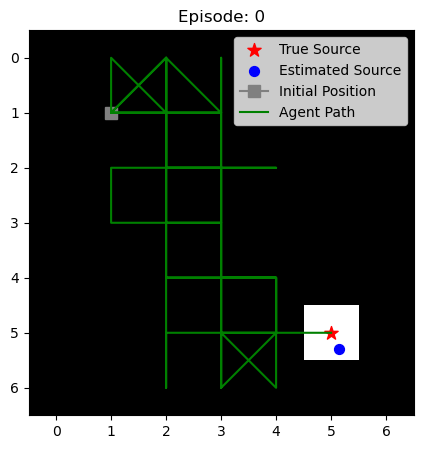

In [10]:
for i in range(200):
    current_state = np.array([1, 1])  # Reset the current state
    episode = []
    total_reward = 0
    agent_path = []
    episode_error = None  # Initialize episode error


    while True:

        # Particle filter estimation
        particles = particle_filter_estimate(100, 10) # Using only 100 particles to speed up the execution
        plume_estimation, plume_variance = estimate_source(particles)

        plume_estimation = np.mean(particles, axis=0)
        plume_variance = np.var(particles, axis=0)

        # Track estimated source location and variance
        estimations.append(plume_estimation)
        variances.append(plume_variance)

        # Update cumulative rewards
        cumulative_rewards += total_reward

        # Calculate error between estimated source and true source
        error = np.linalg.norm(plume_estimation - np.array([5, 5]))

        # Update the episode error if it's the first error encountered
        if episode_error is None:
            episode_error = error

        # Append the error value to the list
        errors.append(error)

        # Predict action probabilities
        s = conv_to_onehot(current_state)
        action_prob = actor_net(s).detach().numpy()
        action_prob += 0.2
        action_prob = action_prob / np.sum(action_prob)
        action_idx = np.random.choice(range(4), p=action_prob)

        # Move
        prev_state = current_state
        current_state = current_state + actions[action_idx]

        # Reward
        concentration = calculate_concentration(current_state)
        reward = concentration
        total_reward += reward

        # Calculate cumulative average of rewards
        cumulative_average = cumulative_rewards / (i + 1)

        # Save information
        episode.append((s, action_idx, conv_to_onehot(current_state), reward))
        agent_path.append(current_state)

        

        # If there is a collision, go back to the previous state
        if maze[current_state[0], current_state[1]] == -1:
            current_state = prev_state

        # If goal is reached, break the loop
        if maze[current_state[0], current_state[1]] == 1:
            break

    # Update actor and critic networks
    loss_critic = 0
    loss_actor = 0
    for _ in range(200):
        # Learn Q-values
        loss_critic = 0
        for s, a, next_s, r in episode:
            q_value = critic_net(s, torch.eye(action_size)[a])
            next_a = torch.argmax(actor_net(next_s))
            next_a = torch.eye(action_size)[next_a]
            q_value_next = critic_net(next_s, next_a).detach()
            loss_critic += (r + gamma * q_value_next - q_value) ** 2
        optimizer_critic.zero_grad()
        loss_critic.backward()
        optimizer_critic.step()

        # Learn the action that maximizes Q-value
        loss_actor = 0
        for s, _, _, _ in episode:
            loss_actor += -critic_net(s, actor_net(s))
        optimizer_actor.zero_grad()
        loss_actor.backward()
        optimizer_actor.step()

    # Track metrics and agent paths
    critic_losses.append(loss_critic.item() / len(episode))
    actor_losses.append(loss_actor.item() / len(episode))
    rewards.append(total_reward)
    agent_paths.append(agent_path)
    rewards_avg.append(np.mean(rewards[-100:]))  # Moving average of rewards
    rewards_cumulative.append(cumulative_average) # Cumulative average of rewards

    # Visualization
    if i % 10 == 0:
        # print("critic loss:", loss_critic / len(episode))
        # print("actor loss:", loss_actor / len(episode))
        print("reward:", total_reward)
        print("errors:", error)
        print("episode:", i)
        print("=====================================")
        # show_policy(agent_path, plume_estimation, plume_variance, i)

        # Plot the maze with plume concentration, agent path, particles, estimated source location, and true source location
        fig, ax = plt.subplots(figsize=(5, 5))
        # Plot the maze with plume concentration
        ax.imshow(maze, cmap='coolwarm', origin='upper', vmin=0.001, vmax=0.002)
        # Plot the agent path
        ax.plot([state[1] for state in agent_path], [state[0] for state in agent_path], color='green', label='Agent Path')
        # Plot the particles
        ax.scatter([particle[1] for particle in particles], [particle[0] for particle in particles], color='orange', marker='x', label='Particles')
        # Plot the true source location
        ax.plot(plume_center[1], plume_center[0], color='red', marker='*', markersize=10, label='True Source')
        # Plot the estimated source location
        ax.plot(plume_estimation[1], plume_estimation[0], color='blue', marker='o', markersize=5, label='Estimated Source')
        # Add square to show initial position of the agent
        ax.plot(current_state[1], current_state[0], color='gray', marker='s', markersize=8, label='Initial Position')

        ax.legend(loc='upper left', frameon=False)
        ax.set_title("Episode: {}".format(i))

        # Add colorbar manually
        sm = plt.cm.ScalarMappable(cmap='coolwarm')
        sm.set_array([])  # Set an empty array to create a colorbar
        fig.colorbar(sm, ax=ax, label='Plume Concentration')

        # Convert the plot to an image
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)

        # Append the image to the frames list
        frames.append(image)

# Create the animation
fig, ax = plt.subplots(figsize=(5, 5))
ani = animation.FuncAnimation(fig, update_frame, frames=len(frames), fargs=(ax, maze, plume_center, plume_estimation, agent_paths))

# Save the animation as a GIF
ani.save('DDPG_No Obstacles_200 Episodes.gif', writer='pillow', fps=3)

### Plot the Graphs to Analyse the Performance

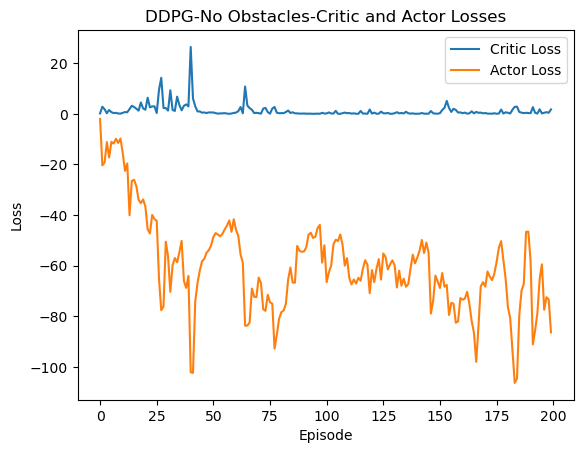

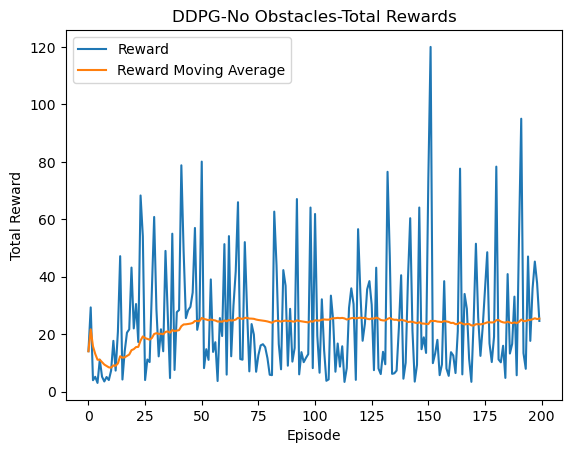

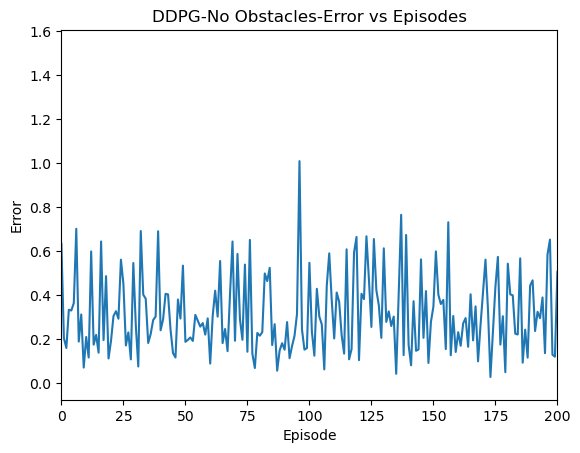

In [11]:
# Plot the critic and actor losses
plt.figure()
plt.plot(critic_losses, label='Critic Loss')
plt.plot(actor_losses, label='Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('DDPG-No Obstacles-Critic and Actor Losses')
plt.legend()

# Plot the total rewards and moving average of rewards
plt.figure()
plt.plot(rewards, label='Reward')
plt.plot(rewards_avg, label='Reward Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DDPG-No Obstacles-Total Rewards')
plt.legend()

# Plot the error values vs episodes
plt.figure()
plt.plot(range(len(errors)), errors)
plt.xlabel('Episode')
plt.ylabel('Error')
plt.title('DDPG-No Obstacles-Error vs Episodes')
plt.xlim(0, 200)

# Display the animation and plots
plt.show()